In [453]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import scipy.stats as sts
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

pd.options.mode.chained_assignment = None
%matplotlib inline

file = 'rates 12052021.csv'

In [454]:
import chardet
with open(file, 'rb') as rawdata:
    result = chardet.detect(rawdata.read(100000))
result

{'encoding': 'windows-1251',
 'confidence': 0.8592048592477813,
 'language': 'Bulgarian'}

In [455]:
df = pd.read_csv(file, encoding='windows-1251', sep=';', header=1)

In [456]:
df_sliced = df[['SECID', 'NAME', 'FACEVALUE', 'FACEUNIT', 'DURATION', 'COUPONFREQUENCY', 'COUPONDATE', 'MATDATE', 'COUPONPERCENT', 'COUPONVALUE', 'COUPONDAYSPASSED', 'COUPONDAYSREMAIN', 'COUPONLENGTH', 'PRICE', 'PRICE_RUB']]

In [457]:
df_rub = df_sliced[df_sliced['FACEUNIT']=='RUB']

In [503]:
df_rub.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1699 entries, 9 to 2545
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   SECID             1699 non-null   object        
 1   NAME              1699 non-null   object        
 2   FACEVALUE         1699 non-null   float64       
 3   FACEUNIT          1699 non-null   object        
 4   DURATION          1306 non-null   float64       
 5   COUPONFREQUENCY   1699 non-null   float64       
 6   COUPONDATE        1699 non-null   datetime64[ns]
 7   MATDATE           1699 non-null   datetime64[ns]
 8   COUPONPERCENT     1699 non-null   float64       
 9   COUPONVALUE       1699 non-null   float64       
 10  COUPONDAYSPASSED  1699 non-null   float64       
 11  COUPONDAYSREMAIN  1699 non-null   float64       
 12  COUPONLENGTH      1699 non-null   float64       
 13  PRICE             1699 non-null   float64       
 14  PRICE_RUB         1699 n

In [459]:
df_rub.dropna(subset=['COUPONPERCENT', 'COUPONFREQUENCY', 'MATDATE', 'COUPONVALUE', 'PRICE_RUB'], inplace=True)

In [460]:
def convert(val):
    """
    Convert the string number value to a float
     - Remove commas
     - Convert to float type
    """
    new_val = val.replace(',','.')
    return float(new_val)

In [461]:
df_rub['COUPONPERCENT'] = df_rub['COUPONPERCENT'].apply(convert)
df_rub['COUPONVALUE'] = df_rub['COUPONVALUE'].apply(convert)
df_rub['FACEVALUE'] = df_rub['FACEVALUE'].apply(convert)
df_rub['PRICE'] = df_rub['PRICE'].apply(convert)
df_rub['PRICE_RUB'] = df_rub['PRICE_RUB'].apply(convert)
df_rub['COUPONDATE'] =df_rub['COUPONDATE'].apply(pd.to_datetime)
df_rub['MATDATE'] = df_rub['MATDATE'].apply(pd.to_datetime)

In [462]:
X = df_rub.iloc[:, [8, 14]].values

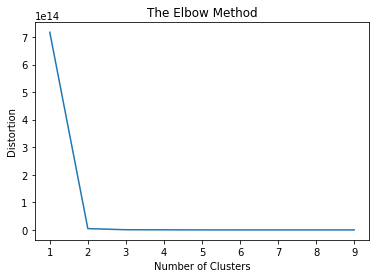

In [463]:
distortion = []
K = range(1, 10)
for k in K:
    model = KMeans(n_clusters=k, random_state=12345)
    model.fit(X)
    distortion.append(model.inertia_) 
plt.plot(K, distortion)
plt.title('The Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('Distortion');

In [464]:
model = KMeans(n_clusters=2, random_state=12345)
y_means = model.fit_predict(X)

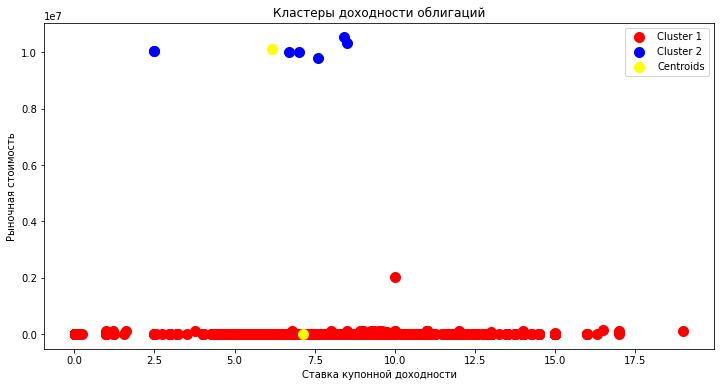

In [465]:
fig, ax = plt.subplots(figsize=(12, 6))
plt.scatter(X[y_means == 0, 0], X[y_means == 0, 1], s=100, c='red', label='Cluster 1')
plt.scatter(X[y_means == 1, 0], X[y_means == 1, 1], s=100, c='blue', label='Cluster 2')
plt.scatter(model.cluster_centers_[:, 0], model.cluster_centers_[:, 1], s=100, c='yellow', label='Centroids')
plt.title('Кластеры доходности облигаций')
plt.ylabel('Рыночная стоимость')
plt.xlabel('Cтавка купонной доходности')
plt.legend();

In [466]:
df_rub['NKD'] = df_rub['FACEVALUE'] * (df_rub['COUPONPERCENT'] / 100) / df_rub['COUPONFREQUENCY'] * df_rub['COUPONDAYSPASSED'] / df_rub['COUPONLENGTH'] 

In [467]:
df_rub['COUPONLEFT'] = abs(df_rub['MATDATE'] - df_rub['COUPONDATE']).dt.days // df_rub['COUPONLENGTH'] + 1

In [468]:
def profit_count(price, best_price, nkd, coupon_price, coupon_left, end_date, last_date, last_remain):
    buy = price * (best_price / 100) + nkd
    if price * (best_price / 100) >= price:
        earnings = (coupon_price * coupon_left) - (0.13 * coupon_price * coupon_left) + price
    else:
        earnings = (coupon_price * coupon_left) - (0.13 * coupon_price * coupon_left) + price - 0.13 * (price - price * (best_price / 100))
    profit = ((earnings - buy) * 100 / buy) / (abs(end_date - last_date).days + last_remain) * 365
    return profit

In [469]:
df_rub['PROFIT'] = df_rub.apply(lambda row: profit_count(row['FACEVALUE'], row['PRICE'], row['NKD'], row['COUPONVALUE'], row['COUPONLEFT'], row['MATDATE'], row['COUPONDATE'], row['COUPONDAYSREMAIN']), axis=1)

In [471]:
df_rub.head(10)

,SECID,NAME,FACEVALUE,FACEUNIT,DURATION,COUPONFREQUENCY,COUPONDATE,MATDATE,COUPONPERCENT,COUPONVALUE,COUPONDAYSPASSED,COUPONDAYSREMAIN,COUPONLENGTH,PRICE,PRICE_RUB,NKD,COUPONLEFT,PROFIT
9,RU000A0JNYN1,Гор.Обл.Займ Москвы 48 в.,1000.0,RUB,379.0,2.0,2021-11-06,2022-11-06,6.00,29.92,152.0,30.0,182.0,100.1180,1026.1700,25.054945,3.0,4.669282
11,RU000A0JQ7Z2,"""Российские ЖД"" ОАО 19 обл.",1000.0,RUB,1020.0,2.0,2021-12-07,2024-08-07,7.85,39.14,121.0,61.0,182.0,103.1950,1057.9700,26.094780,6.0,4.875194
12,RU000A0JQ8V9,Мечел ПАО 04 обл.,50.0,RUB,64.0,4.0,2021-07-15,2021-07-15,8.00,1.00,27.0,64.0,91.0,253.9698,127.2849,0.296703,1.0,-342.378564
13,RU000A0JQAL8,ДОМ.РФ (АО) обл. сер. А14,1000.0,RUB,677.0,2.0,2021-05-15,2023-05-15,6.75,33.47,178.0,3.0,181.0,105.4370,1087.2900,33.190608,5.0,2.657156
14,RU000A0JQAM6,ДОМ.РФ (АО) обл. сер. А15,1000.0,RUB,2172.0,2.0,2021-09-15,2028-09-15,6.75,34.03,58.0,126.0,184.0,113.3870,1144.6000,10.638587,14.0,3.209073
15,RU000A0JQRD9,"""Российские ЖД"" ОАО 23 обл.",1000.0,RUB,1171.0,2.0,2021-07-22,2025-01-16,7.85,39.14,111.0,71.0,182.0,103.7870,1061.7400,23.938187,8.0,5.382644
16,RU000A0JQXG0,ДОМ.РФ (АО) обл. сер. А16,100.0,RUB,124.0,4.0,2021-06-15,2021-09-15,8.25,2.08,58.0,34.0,92.0,101.0875,102.3975,1.300272,2.0,3.484042
17,RU000A0JR4U9,Главная дорога АО об.сер. 03,1000.0,RUB,1315.0,1.0,2021-08-11,2028-10-30,4.00,39.89,184.0,180.0,364.0,97.8880,999.0400,20.219780,8.0,3.576631
18,RU000A0JR5F7,ДОМ.РФ (АО) обл. сер.А17,150.0,RUB,326.0,4.0,2021-07-15,2022-04-15,9.05,3.38,27.0,64.0,91.0,102.6520,154.9780,1.006937,4.0,4.722303
19,RU000A0JRDY3,ДОМ.РФ (АО) обл. сер.А18,700.0,RUB,18.0,4.0,2021-07-15,2023-07-15,5.25,9.16,27.0,64.0,91.0,100.9650,709.4750,2.725962,9.0,4.032868


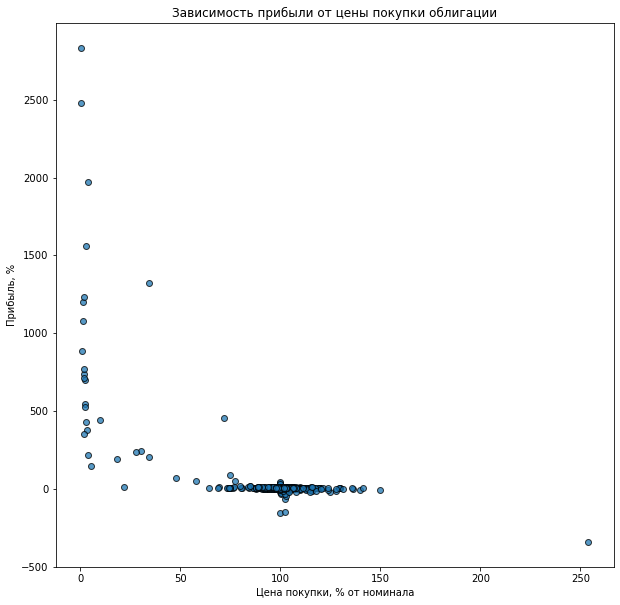

In [495]:
fig, ax = plt.subplots(figsize = (10, 10))
plt.scatter(df_rub['PRICE'], df_rub['PROFIT'], edgecolor='black', alpha=0.75, linewidth=1)

plt.title('Зависимость прибыли от цены покупки облигации')
plt.xlabel('Цена покупки, % от номинала')
plt.ylabel('Прибыль, %')
plt.show()

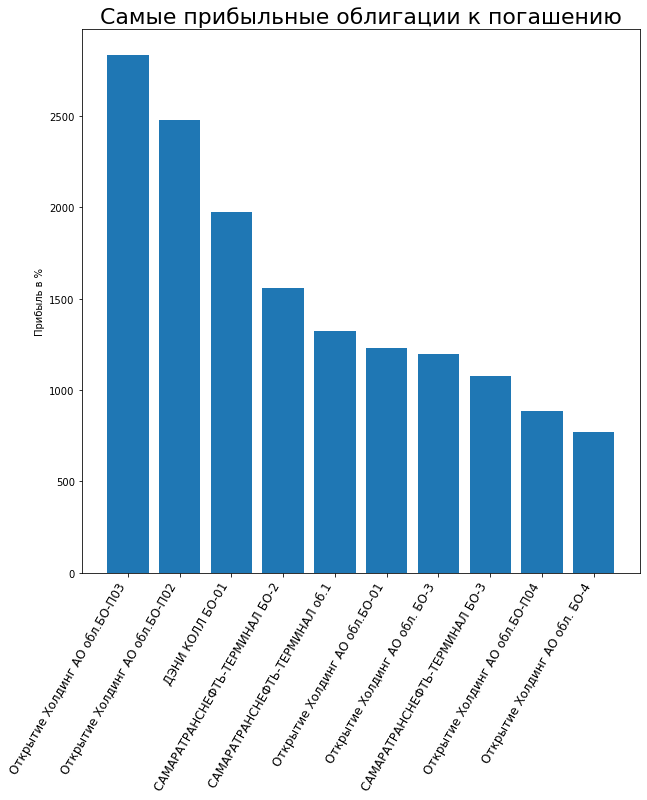

In [494]:
fig, ax = plt.subplots(figsize = (10, 10))
top_profit = df_rub.sort_values(by='PROFIT', ascending=False).head(10)
ax.bar(top_profit['NAME'], top_profit['PROFIT'])
ax.set_xticklabels(top_profit['NAME'], rotation=60, horizontalalignment='right', fontsize='12')

ax.set_title('Самые прибыльные облигации к погашению', fontsize=22)
ax.set_ylabel('Прибыль в %')

plt.show()

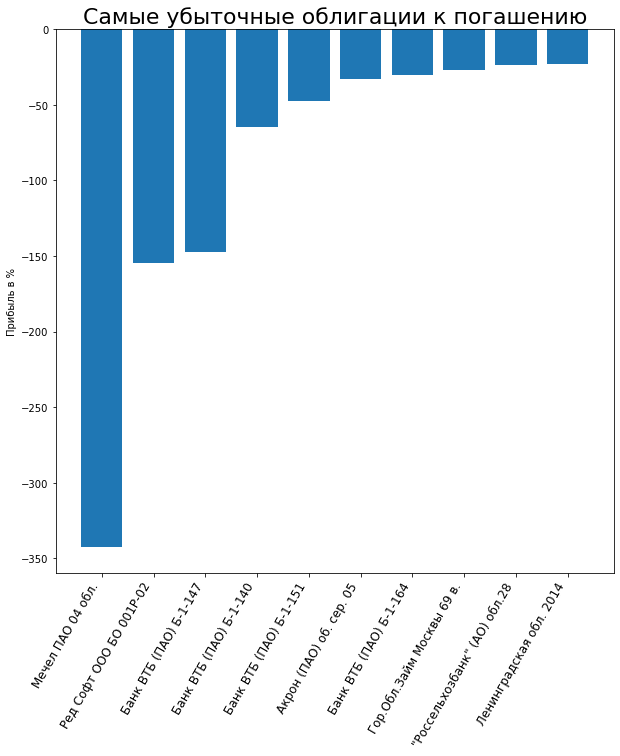

In [497]:
fig, ax = plt.subplots(figsize = (10, 10))
top_profit = df_rub.sort_values(by='PROFIT', ascending=True).head(10)
ax.bar(top_profit['NAME'], top_profit['PROFIT'])
ax.set_xticklabels(top_profit['NAME'], rotation=60, horizontalalignment='right', fontsize='12')

ax.set_title('Самые убыточные облигации к погашению', fontsize=22)
ax.set_ylabel('Прибыль в %')

plt.show()

In [511]:
start, end = pd.to_datetime(["13MAY2021:00:00:00", "21MAY2021:00:00:00"], 
                            format='%d%b%Y:%H:%M:%S')

df_rub[(df_rub['COUPONDATE'] <= end) & (df_rub['COUPONDATE'] >= start)].sort_values(by='PROFIT', ascending=False).head(20)

,SECID,NAME,FACEVALUE,FACEUNIT,DURATION,COUPONFREQUENCY,COUPONDATE,MATDATE,COUPONPERCENT,COUPONVALUE,COUPONDAYSPASSED,COUPONDAYSREMAIN,COUPONLENGTH,PRICE,PRICE_RUB,NKD,COUPONLEFT,PROFIT
2425,XS2045847295,BCS SP Plc ALOR LV1,75000.00,RUB,NaN,2.0,2021-05-15,2022-11-15,10.00,3716.54,178.0,3.0,181.0,84.970,63727.500,3687.845304,4.0,18.687602
2461,XS2123084639,BCS SP Plc Series 2020-4,75000.00,RUB,NaN,2.0,2021-05-15,2023-05-15,10.00,3716.54,178.0,3.0,181.0,85.000,63750.000,3687.845304,5.0,16.441415
1355,RU000A101D96,СФО РуСол 1 класс В,984.67,RUB,NaN,4.0,2021-05-15,2031-02-15,14.27,34.27,86.0,3.0,89.0,100.000,1017.780,33.944009,41.0,11.942327
1019,RU000A100CT0,Онлайн Микрофинанс БО-01,1000.00,RUB,12.0,4.0,2021-05-20,2022-05-19,15.00,37.40,83.0,8.0,91.0,100.248,1036.590,34.203297,5.0,11.926073
749,RU000A0ZZ8A2,ПЮДМ ООО БО-П01,50000.00,RUB,6.0,12.0,2021-05-14,2023-04-05,15.00,616.44,28.0,2.0,30.0,102.250,51700.340,583.333333,24.0,11.370444
2126,RU000A102ZT7,МФК Быстроденьги 02,1000.00,RUB,875.0,12.0,2021-05-13,2024-03-28,12.75,10.48,29.0,1.0,30.0,100.658,1016.710,10.270833,36.0,10.634755
1855,RU000A102CZ3,Онлайн Микрофинанс 03,1000.00,RUB,775.0,12.0,2021-05-16,2023-02-11,12.50,10.27,26.0,4.0,30.0,100.188,1010.780,9.027778,22.0,10.474173
1273,RU000A1014P9,МФК КарМани БО-1-03,800.00,RUB,335.0,12.0,2021-05-14,2022-12-24,15.00,10.19,29.0,2.0,31.0,103.668,838.874,9.354839,20.0,10.206692
1200,RU000A100YD8,Нафтатранс плюс ООО БО-02,10000.00,RUB,653.0,12.0,2021-05-15,2024-09-26,13.00,106.85,27.0,3.0,30.0,102.440,10340.160,97.500000,42.0,10.198530
1024,RU000A100DC4,МСБ-Лизинг 002Р-02,770.87,RUB,483.0,12.0,2021-05-16,2024-04-30,12.75,8.08,26.0,4.0,30.0,101.757,791.414,7.098428,37.0,10.186507


In [202]:
df_rub['CLUSTER'] = y_meansS

<ipython-input-202-9bd3458e1619>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rub['CLUSTER'] = y_means
